In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


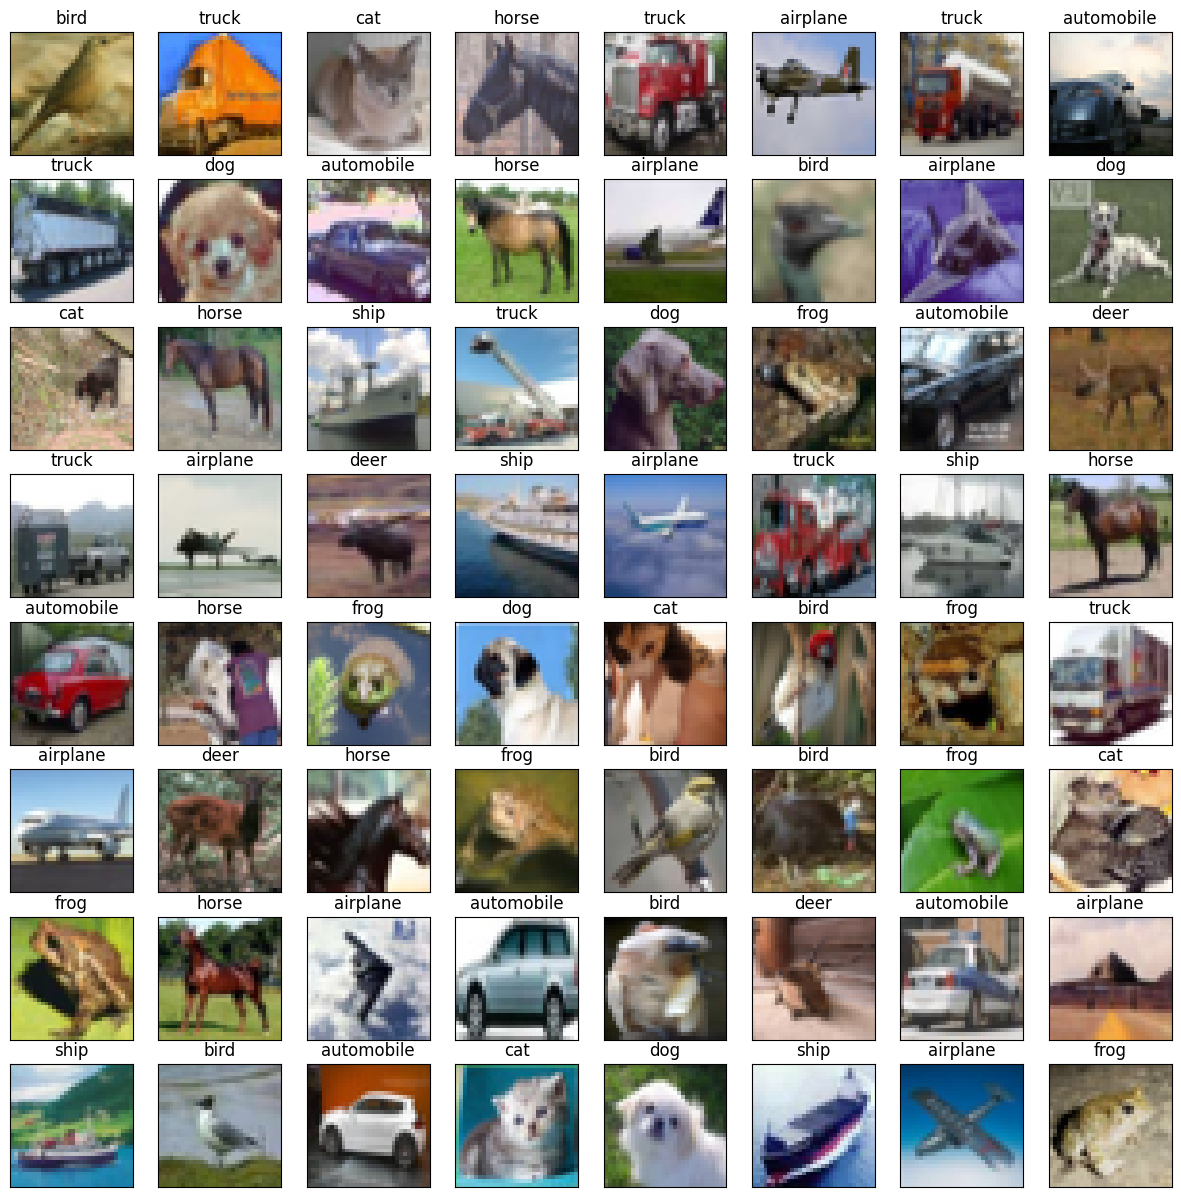

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [4]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

model.summary()


2024-02-19 13:09:08.383037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 13:09:08.404952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 13:09:08.405172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [5]:
# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 300

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

Epoch 1/300


2024-02-19 13:09:10.827469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-19 13:09:11.773141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-19 13:09:12.402562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-19 13:09:12.404131: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fcb6730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 13:09:12.404160: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-19 13:09:12.409727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] d

704/704 - 26s - loss: 2.3918 - accuracy: 0.3299 - val_loss: 1.6551 - val_accuracy: 0.4450 - lr: 5.0000e-04 - 26s/epoch - 38ms/step
Epoch 2/300
704/704 - 21s - loss: 1.7059 - accuracy: 0.4611 - val_loss: 1.5459 - val_accuracy: 0.5234 - lr: 5.0000e-04 - 21s/epoch - 30ms/step
Epoch 3/300
704/704 - 21s - loss: 1.4613 - accuracy: 0.5348 - val_loss: 1.3348 - val_accuracy: 0.5802 - lr: 5.0000e-04 - 21s/epoch - 29ms/step
Epoch 4/300
704/704 - 21s - loss: 1.2928 - accuracy: 0.5851 - val_loss: 1.1497 - val_accuracy: 0.6382 - lr: 5.0000e-04 - 21s/epoch - 29ms/step
Epoch 5/300
704/704 - 21s - loss: 1.1783 - accuracy: 0.6246 - val_loss: 1.0856 - val_accuracy: 0.6596 - lr: 5.0000e-04 - 21s/epoch - 30ms/step
Epoch 6/300
704/704 - 21s - loss: 1.0909 - accuracy: 0.6538 - val_loss: 0.9926 - val_accuracy: 0.6944 - lr: 5.0000e-04 - 21s/epoch - 30ms/step
Epoch 7/300
704/704 - 21s - loss: 1.0448 - accuracy: 0.6734 - val_loss: 0.9284 - val_accuracy: 0.7206 - lr: 5.0000e-04 - 21s/epoch - 30ms/step
Epoch 8/300

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)